In [125]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [92]:
DATASET_PATH = "Dataset/images"

In [93]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 30 


In [94]:
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  
    rotation_range=30,     
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,         
    horizontal_flip=True,
    fill_mode="nearest"
)

In [95]:
train_generator = data_gen.flow_from_directory(
    DATASET_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

validation_generator = data_gen.flow_from_directory(
    DATASET_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)

Found 7207 images belonging to 30 classes.
Found 1788 images belonging to 30 classes.


In [96]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [97]:
for layer in base_model.layers[-20:]:
    layer.trainable = True


In [98]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

In [99]:
model = Model(inputs=base_model.input, outputs=output)

In [100]:
base_model.trainable = True 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),  
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [101]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.3, 
    patience=3,  
    min_lr=1e-6,  
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,  
    min_delta=0.002,  
    restore_best_weights=True
)

In [102]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr] 
)

Epoch 1/50
225/225 [==============================] - 314s 1s/step - loss: 2.9215 - accuracy: 0.2170 - val_loss: 3.5146 - val_accuracy: 0.0312 - lr: 3.0000e-05
Epoch 2/50
225/225 [==============================] - 303s 1s/step - loss: 1.4987 - accuracy: 0.6020 - val_loss: 3.3935 - val_accuracy: 0.0466 - lr: 3.0000e-05
Epoch 3/50
225/225 [==============================] - 298s 1s/step - loss: 0.9618 - accuracy: 0.7377 - val_loss: 1.9038 - val_accuracy: 0.4631 - lr: 3.0000e-05
Epoch 4/50
225/225 [==============================] - 301s 1s/step - loss: 0.7242 - accuracy: 0.8056 - val_loss: 0.8079 - val_accuracy: 0.7716 - lr: 3.0000e-05
Epoch 5/50
225/225 [==============================] - 299s 1s/step - loss: 0.6130 - accuracy: 0.8372 - val_loss: 0.4484 - val_accuracy: 0.8903 - lr: 3.0000e-05
Epoch 6/50
225/225 [==============================] - 303s 1s/step - loss: 0.5172 - accuracy: 0.8549 - val_loss: 0.4036 - val_accuracy: 0.8989 - lr: 3.0000e-05
Epoch 7/50
225/225 [====================

In [103]:
from sklearn.metrics import classification_report
import numpy as np

y_true = []
y_pred = []

class_labels = list(train_generator.class_indices.keys())

for _ in range(len(validation_generator)):
    x_batch, y_batch = validation_generator.next()
    preds = model.predict(x_batch)
    y_true.extend(np.argmax(y_batch, axis=1))  
    y_pred.extend(np.argmax(preds, axis=1))  


print(classification_report(y_true, y_pred, target_names=class_labels))

1/1 [==============================] - 2s 2s/step
                       precision    recall  f1-score   support

         Ajanta Caves       0.73      0.61      0.67        62
            Amer Fort       1.00      0.86      0.93        59
Brihadeeswarar Temple       0.92      0.75      0.82        59
            Charminar       0.98      0.98      0.98        59
          City Palace       0.78      0.82      0.80        60
      Elephanta Caves       0.88      0.90      0.89        59
         Ellora Caves       0.61      0.80      0.69        60
       Fatehpur Sikri       0.93      0.97      0.95        59
     Gateway of India       0.98      0.98      0.98        59
        Golconda Fort       0.91      0.97      0.94        60
           Hawa Mahal       0.95      0.98      0.97        59
       Humayun's Tomb       0.97      0.97      0.97        59
       Jaisalmer Fort       0.98      0.93      0.96        59
          Jama Masjid       0.96      0.90      0.93        60
    

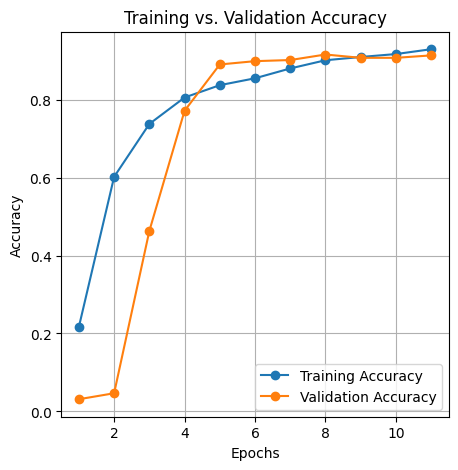

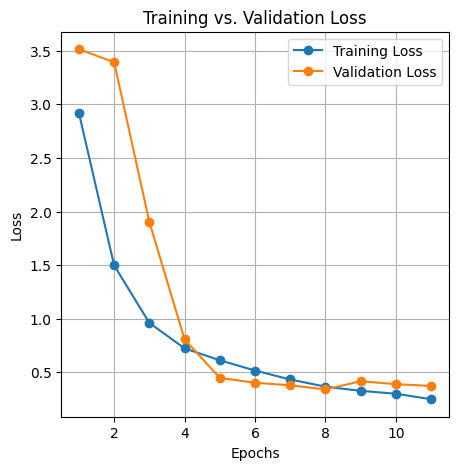

In [104]:
import matplotlib.pyplot as plt


history_dict = history.history  
epochs = range(1, len(history_dict["accuracy"]) + 1)  


plt.figure(figsize=(5, 5))
plt.plot(epochs, history_dict["accuracy"], marker="o", label="Training Accuracy") 
plt.plot(epochs, history_dict["val_accuracy"], marker="o", label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs. Validation Accuracy")
plt.grid(True)
plt.show()


plt.figure(figsize=(5, 5))
plt.plot(epochs, history_dict["loss"], marker="o", label="Training Loss")  
plt.plot(epochs, history_dict["val_loss"], marker="o", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs. Validation Loss")
plt.grid(True)
plt.show()

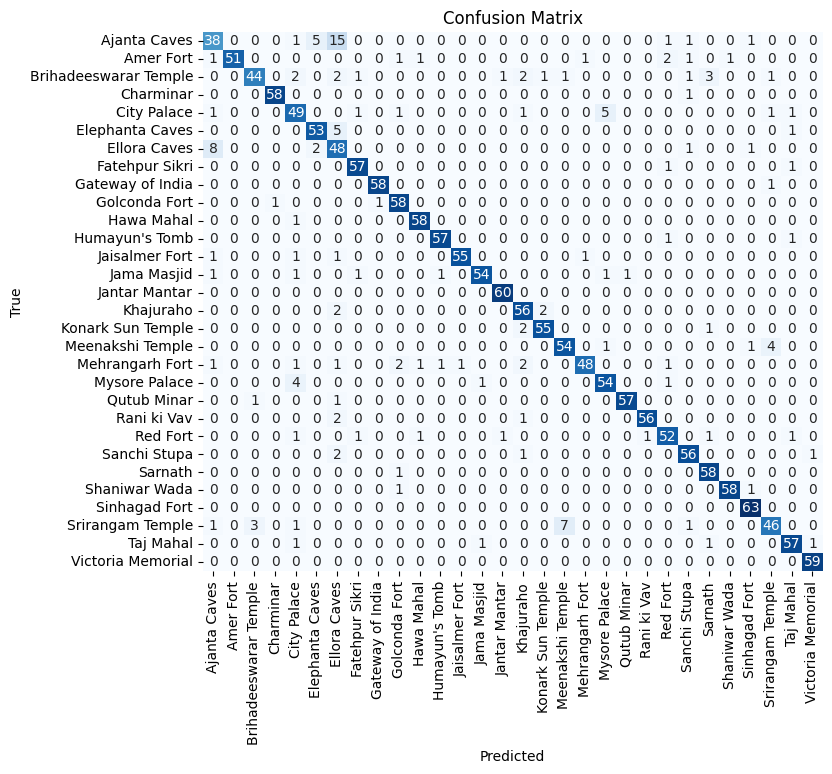

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 7))


sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

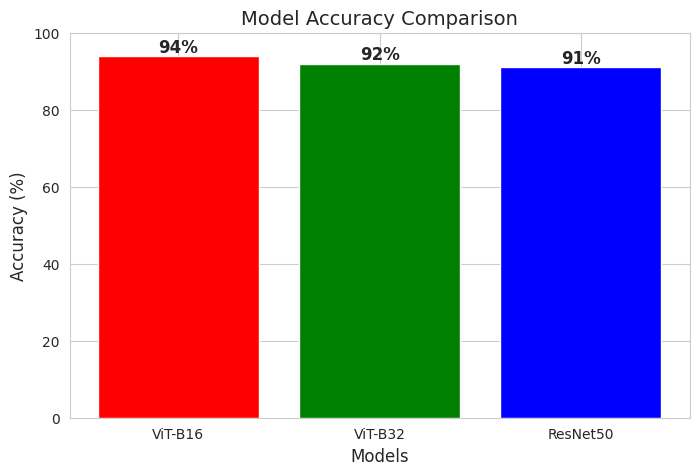

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
models = ['ViT-B16', 'ViT-B32', 'ResNet50']
accuracies = [94, 92, 91]
colors = ['red', 'green', 'blue']  # Different colors for each model

# Set Seaborn style
sns.set_style("whitegrid")

# Create bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=colors)

# Add labels and title
plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.title("Model Accuracy Comparison", fontsize=14)
plt.ylim(0, 100)

# Display accuracy values on top of bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, acc + 1, f"{acc}%", ha='center', fontsize=12, fontweight='bold')

# Show the plot
plt.show()


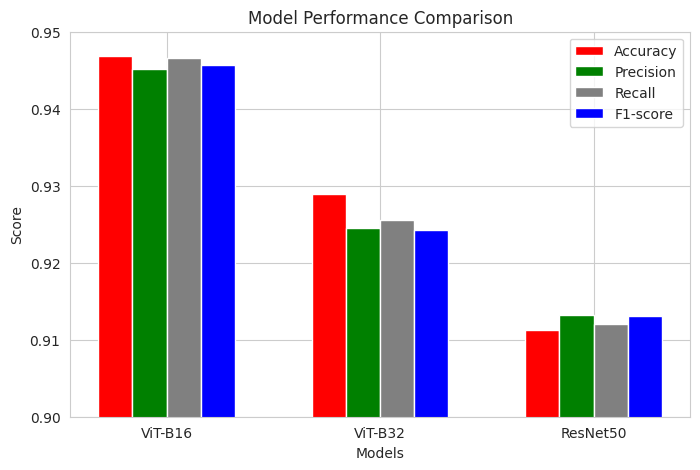

In [123]:
import numpy as np
import matplotlib.pyplot as plt

# Data from the table
models = ['ViT-B16', 'ViT-B32', 'ResNet50']
accuracy = [0.9468, 0.9289, 0.9112]
precision = [0.9452, 0.9245, 0.9132]
recall = [0.9466, 0.9256, 0.9121]
f1_score = [0.9457, 0.9243, 0.9131]

# Bar width and position
bar_width = 0.16
index = np.arange(len(models))

# Plotting bars
plt.figure(figsize=(8, 5))
plt.bar(index, accuracy, bar_width, label='Accuracy', color='r')
plt.bar(index + bar_width, precision, bar_width, label='Precision', color='g')
plt.bar(index + 2 * bar_width, recall, bar_width, label='Recall', color='gray')
plt.bar(index + 3 * bar_width, f1_score, bar_width, label='F1-score', color='b')

# Labels and title
plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.xticks(index + 1.5 * bar_width, models)  # Align model names in the center
plt.legend()
plt.ylim(0.90, 0.95)  # Adjusting y-axis for better visibility

# Show the plot
plt.show()

